<a href="https://colab.research.google.com/github/Rogerio-mack/ABCXYZ/blob/main/imoveis_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import time
start_time = time.time()

In [20]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

path = 'https://github.com/Rogerio-mack/Property-Price-Prediction-Sao-Paulo/raw/refs/heads/main/'


In [21]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error

import statsmodels.api as sm

In [22]:
def error_metrics(y_true, y_pred):

  metrics = {}

  metrics['R2'] = np.round(r2_score(y_true, y_pred),2)
  metrics['RMSE'] = root_mean_squared_error(y_true, y_pred).round(2)
  metrics['MAE'] = mean_absolute_error(y_true, y_pred).round(2)
  metrics['MedAE'] = median_absolute_error(y_true, y_pred).round(2)
  metrics['MAPE'] = mean_absolute_percentage_error(y_true, y_pred).round(2)

  return metrics

In [23]:
def cv_metrics(cv_results,grid_search):

  metrics = {}

  metrics['R2'] = cv_results['mean_test_R2'][grid_search.best_index_].round(2)
  metrics['RMSE'] = cv_results['mean_test_RMSE'][grid_search.best_index_].round(2)
  metrics['MAE'] = cv_results['mean_test_MAE'][grid_search.best_index_].round(2)
  metrics['MedAE'] = cv_results['mean_test_MedAE'][grid_search.best_index_].round(2)
  metrics['MAPE'] = cv_results['mean_test_MAPE'][grid_search.best_index_].round(2)

  return metrics

In [24]:
from IPython.display import display, Latex, HTML
import warnings

def gera_df_stats_latex(df_stats, titulo):

  warnings.filterwarnings('ignore')
  # latex_table = df_stats.style.to_latex(hrules=True)
  latex_table = df_stats.to_latex(index=None)
  # display(Latex(latex_table))

  latex_table = latex_table.replace('tabular','array')
  latex_table = latex_table.replace('toprule','hline')
  latex_table = latex_table.replace('midrule','hline')
  latex_table = latex_table.replace('bottomrule','hline')

  latex_table = '\\textbf{' + titulo + '} \\\\' + latex_table

  warnings.filterwarnings('default')
  return latex_table

In [25]:
df = pd.read_csv(path + 'imoveis_clean_encoded.csv')

# if you want test with few records
np.random.seed(42)
df = df.iloc[ np.random.choice(df.index, size=1000, replace=False) ]

# selecionar a zona
# df = df[ df.zona_SUL == 1 ].reset_index(drop=True)
# df.drop(columns=['zona_LESTE','zona_NORTE','zona_OESTE','zona_SUL'])

# selecionar quartos
# df = df[ df.quartos == 3 ].reset_index(drop=True)
# df.drop(columns=['quartos'])

df.head()

,title,price,location,destaque,condominio,area_util,quartos,banheiros,vagas_na_garagem,iptu,academia,elevador,permitido_animais,piscina,portaria,salao_de_festas,condominio_fechado,seguranca_24h,portao_eletronico,area_murada,area_de_servico,armarios_na_cozinha,armarios_no_quarto,churrasqueira,mobiliado,quarto_de_servico,ar_condicionado,porteiro_24h,varanda,img_index,categoria_Casas,tipo_Casa de vila,tipo_Cobertura,tipo_Duplex ou triplex,tipo_Kitnet,tipo_Loft,tipo_Padrão,zona_LESTE,zona_NORTE,zona_OESTE,zona_SUL
17024,"Apartamento à venda em Pinheiros com 69 m², 2 ...",1795000,491,0,1000,69,2,2,1,10,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,20798,0,0,0,0,0,0,1,0,0,1,0
2910,Apartamento à venda Rua Doutor Fabrício Vampré...,2935000,700,0,1420,153,3,3,2,13,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,3454,0,0,0,0,0,0,1,0,0,0,1
344,Apartamento para venda possui 70 metros quadra...,360000,345,0,800,70,2,1,1,150,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,449,0,0,0,0,0,0,1,0,1,0,0
1034,"APARTAMENTO RESIDENCIAL em São Paulo - SP, Cam...",1090000,25,0,1850,165,3,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1271,0,0,0,0,0,0,1,0,0,0,0
5466,Casa Térrea na Casa Verde - Terreno 9x30m²,600000,565,0,0,160,3,2,2,215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6474,1,0,0,0,0,0,1,0,1,0,0


# GridSearchCV definitions and start results history

In [26]:
%%time
# Some GridSearchCV definitions
# scoring
scoring = {
    'R2': make_scorer(r2_score),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'MedAE': make_scorer(median_absolute_error),
    'MAPE': make_scorer(mean_absolute_percentage_error),
}

# CV k folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_dict = {} # starts results history empty

CPU times: user 1.27 ms, sys: 0 ns, total: 1.27 ms
Wall time: 1.35 ms


# Linear Regression: Numeric

In [27]:
%%time
model_test_name = 'Linear Regression, all coefs'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)
df_model = sm.add_constant(df_model)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df_model['price']
y_pred = results.predict()

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     62.16
Date:                Sun, 20 Oct 2024   Prob (F-statistic):          2.46e-223
Time:                        13:08:54   Log-Likelihood:                -14207.
No. Observations:                1000   AIC:                         2.849e+04
Df Residuals:                     963   BIC:                         2.867e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.29

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33



CPU times: user 77.9 ms, sys: 54.7 ms, total: 133 ms
Wall time: 80.9 ms


## Significant Coefs

In [28]:
def get_features_to_remove(results, p_value_threshold=0.05):

  # Seleciona os coeficientes com p-value maior que 0.05
  coef_pvalues = results.pvalues[results.pvalues > p_value_threshold]

  # Imprime os coeficientes selecionados
  print("Coeficientes com p-value maior que 0.05:")
  print(coef_pvalues)

  features_pvalue_high = list(coef_pvalues.index)
  features_to_remove = []

  for feature in features_pvalue_high:
    if (not feature.startswith('tipo_')) and (not feature.startswith('zona_')): # features compostas, ou removemos todas ou nenhuma
      features_to_remove.append(feature)

  print()
  print('Features to remove: ', features_to_remove)

  return features_to_remove

_ = get_features_to_remove(results)


Coeficientes com p-value maior que 0.05:
location                  0.960357
destaque                  0.951463
quartos                   0.890899
vagas_na_garagem          0.090748
elevador                  0.077467
piscina                   0.090545
portaria                  0.168321
condominio_fechado        0.164834
seguranca_24h             0.622559
portao_eletronico         0.742971
area_murada               0.114688
area_de_servico           0.155238
armarios_na_cozinha       0.708235
armarios_no_quarto        0.620326
churrasqueira             0.054740
mobiliado                 0.559118
quarto_de_servico         0.626258
porteiro_24h              0.086593
varanda                   0.995626
tipo_Casa de vila         0.548822
tipo_Duplex ou triplex    0.608944
tipo_Kitnet               0.220876
tipo_Loft                 0.449748
tipo_Padrão               0.083876
dtype: float64

Features to remove:  ['location', 'destaque', 'quartos', 'vagas_na_garagem', 'elevador', 'piscina', 'po

In [29]:
%%time
model_test_name = 'Linear Regression, only significant coefs'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)
df_model = sm.add_constant(df_model)

features_to_remove = get_features_to_remove(results)
df_model.drop(columns=features_to_remove,inplace=True)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df_model['price']
y_pred = results.predict()

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

Coeficientes com p-value maior que 0.05:
location                  0.960357
destaque                  0.951463
quartos                   0.890899
vagas_na_garagem          0.090748
elevador                  0.077467
piscina                   0.090545
portaria                  0.168321
condominio_fechado        0.164834
seguranca_24h             0.622559
portao_eletronico         0.742971
area_murada               0.114688
area_de_servico           0.155238
armarios_na_cozinha       0.708235
armarios_no_quarto        0.620326
churrasqueira             0.054740
mobiliado                 0.559118
quarto_de_servico         0.626258
porteiro_24h              0.086593
varanda                   0.995626
tipo_Casa de vila         0.548822
tipo_Duplex ou triplex    0.608944
tipo_Kitnet               0.220876
tipo_Loft                 0.449748
tipo_Padrão               0.083876
dtype: float64

Features to remove:  ['location', 'destaque', 'quartos', 'vagas_na_garagem', 'elevador', 'piscina', 'po

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33
1,"Linear Regression, only significant coefs (all)",0.69,363393.70,261854.43,191251.04,0.33



CPU times: user 87.5 ms, sys: 78.4 ms, total: 166 ms
Wall time: 97.5 ms


# Linear Regression: Log Numeric

In [30]:
%%time
model_test_name = 'Linear Regression, log transformer'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)

df_model[['price', 'area_util']] = df_model[['price', 'area_util']].apply(np.log)
df_model = sm.add_constant(df_model)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     89.00
Date:                Sun, 20 Oct 2024   Prob (F-statistic):          8.50e-278
Time:                        13:08:54   Log-Likelihood:                -290.55
No. Observations:                1000   AIC:                             655.1
Df Residuals:                     963   BIC:                             836.7
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33
1,"Linear Regression, only significant coefs (all)",0.69,363393.70,261854.43,191251.04,0.33
2,"Linear Regression, log transformer (all)",0.68,371887.31,247068.25,153829.08,0.26



CPU times: user 96.5 ms, sys: 83.6 ms, total: 180 ms
Wall time: 123 ms


## Significant Coefs

In [31]:
%%time
model_test_name = 'Linear Regression, log transformer'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)

df_model[['price', 'area_util']] = df_model[['price', 'area_util']].apply(np.log)
df_model = sm.add_constant(df_model)

features_to_remove = get_features_to_remove(results)
df_model.drop(columns=features_to_remove,inplace=True)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

Coeficientes com p-value maior que 0.05:
location                  0.124632
destaque                  0.912435
quartos                   0.093546
academia                  0.472310
elevador                  0.118773
portaria                  0.416406
condominio_fechado        0.051326
seguranca_24h             0.510224
portao_eletronico         0.880174
area_murada               0.157681
area_de_servico           0.328386
armarios_na_cozinha       0.526613
armarios_no_quarto        0.462347
churrasqueira             0.241490
mobiliado                 0.242141
quarto_de_servico         0.909908
porteiro_24h              0.068494
varanda                   0.574056
tipo_Casa de vila         0.425754
tipo_Duplex ou triplex    0.401006
tipo_Loft                 0.591020
dtype: float64

Features to remove:  ['location', 'destaque', 'quartos', 'academia', 'elevador', 'portaria', 'condominio_fechado', 'seguranca_24h', 'portao_eletronico', 'area_murada', 'area_de_servico', 'armarios_na_cozinha'

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33
1,"Linear Regression, only significant coefs (all)",0.69,363393.70,261854.43,191251.04,0.33
2,"Linear Regression, log transformer (all)",0.67,373490.70,250244.71,155172.11,0.27



CPU times: user 76.4 ms, sys: 75.3 ms, total: 152 ms
Wall time: 86.9 ms


In [32]:
df_model_log = df_model.copy() # to be used in interations

# Linear Regression: Log Numeric + Interactions

In [40]:
%%time
model_test_name = 'Linear Regression, log with interactions'

df_model = df_model_log.copy()

df_model['area_util_quartos'] =  df_model['area_util'] * df_model['quartos']
df_model['area_util_banheiros'] =  df_model['area_util'] * df_model['banheiros']
df_model['area_util_categoria_Casas'] =  df_model['area_util'] * df_model['categoria_Casas']
df_model['price_area_util'] =  df['price'] * df['area_util'] # não usando o log preco e area_util

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     221.8
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:11:59   Log-Likelihood:                -108.53
No. Observations:                1000   AIC:                             265.1
Df Residuals:                     976   BIC:                             382.8
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33
1,"Linear Regression, only significant coefs (all)",0.69,363393.70,261854.43,191251.04,0.33
2,"Linear Regression, log transformer (all)",0.67,373490.70,250244.71,155172.11,0.27
3,Decision Tree (CV),0.27,546747.59,358915.55,193695.20,0.41
4,Decision Tree (test),0.42,512713.70,347768.65,195000.50,0.41
5,Decision Tree (all),1.00,8.89,0.60,0.00,0.00
6,Random Forest (CV),0.66,373052.16,255488.21,158293.09,0.30
7,Random Forest (test),0.76,329438.77,222056.43,145815.74,0.27
8,Random Forest (all),0.96,130296.62,88421.16,57367.88,0.10
9,Linear Regression (CV),0.65,380773.76,273151.41,195334.60,0.34



CPU times: user 83.5 ms, sys: 33.4 ms, total: 117 ms
Wall time: 95.9 ms


## Significant Coefs

In [41]:
%%time
model_test_name = 'Linear Regression, log with interactions'

df_model = df_model_log.copy()

df_model['area_util_quartos'] =  df_model['area_util'] * df_model['quartos']
df_model['area_util_banheiros'] =  df_model['area_util'] * df_model['banheiros']
df_model['area_util_categoria_Casas'] =  df_model['area_util'] * df_model['categoria_Casas']
df_model['price_area_util'] =  df['price'] * df['area_util'] # não usando o log preco e area_util

features_to_remove = get_features_to_remove(results)
df_model.drop(columns=features_to_remove,inplace=True)

results = sm.OLS(df_model['price'], df_model.drop(['price'],axis=1)).fit()

print(results.summary())

y_true = df['price']
y_pred = np.exp(results.predict())

print()
results_dict[model_test_name + ' (all)'] = error_metrics(y_true, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()

Coeficientes com p-value maior que 0.05:
categoria_Casas              0.373077
tipo_Casa de vila            0.210842
tipo_Cobertura               0.619737
tipo_Kitnet                  0.236616
tipo_Loft                    0.122368
tipo_Padrão                  0.918201
area_util_quartos            0.411600
area_util_categoria_Casas    0.223171
dtype: float64

Features to remove:  ['categoria_Casas', 'area_util_quartos', 'area_util_categoria_Casas']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     253.9
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:12:25   Log-Likelihood:                -111.69
No. Observations:                1000   AIC:                             2

,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33
1,"Linear Regression, only significant coefs (all)",0.69,363393.70,261854.43,191251.04,0.33
2,"Linear Regression, log transformer (all)",0.67,373490.70,250244.71,155172.11,0.27
3,Decision Tree (CV),0.27,546747.59,358915.55,193695.20,0.41
4,Decision Tree (test),0.42,512713.70,347768.65,195000.50,0.41
5,Decision Tree (all),1.00,8.89,0.60,0.00,0.00
6,Random Forest (CV),0.66,373052.16,255488.21,158293.09,0.30
7,Random Forest (test),0.76,329438.77,222056.43,145815.74,0.27
8,Random Forest (all),0.96,130296.62,88421.16,57367.88,0.10
9,Linear Regression (CV),0.65,380773.76,273151.41,195334.60,0.34



CPU times: user 90.3 ms, sys: 46.1 ms, total: 136 ms
Wall time: 156 ms


[]

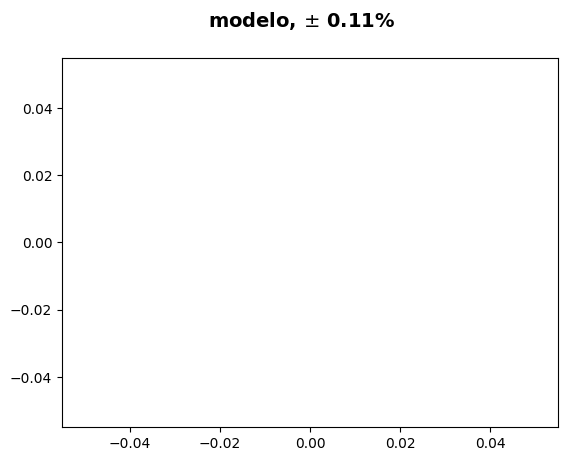

In [116]:
erro =0.2
titulo = 'modelo'
erro = error_metrics(y_true, y_pred)['MAPE']/2
plt.suptitle(titulo + f', $\\pm$ {erro:.2f}%',fontsize=14,weight='bold')
plt.plot()

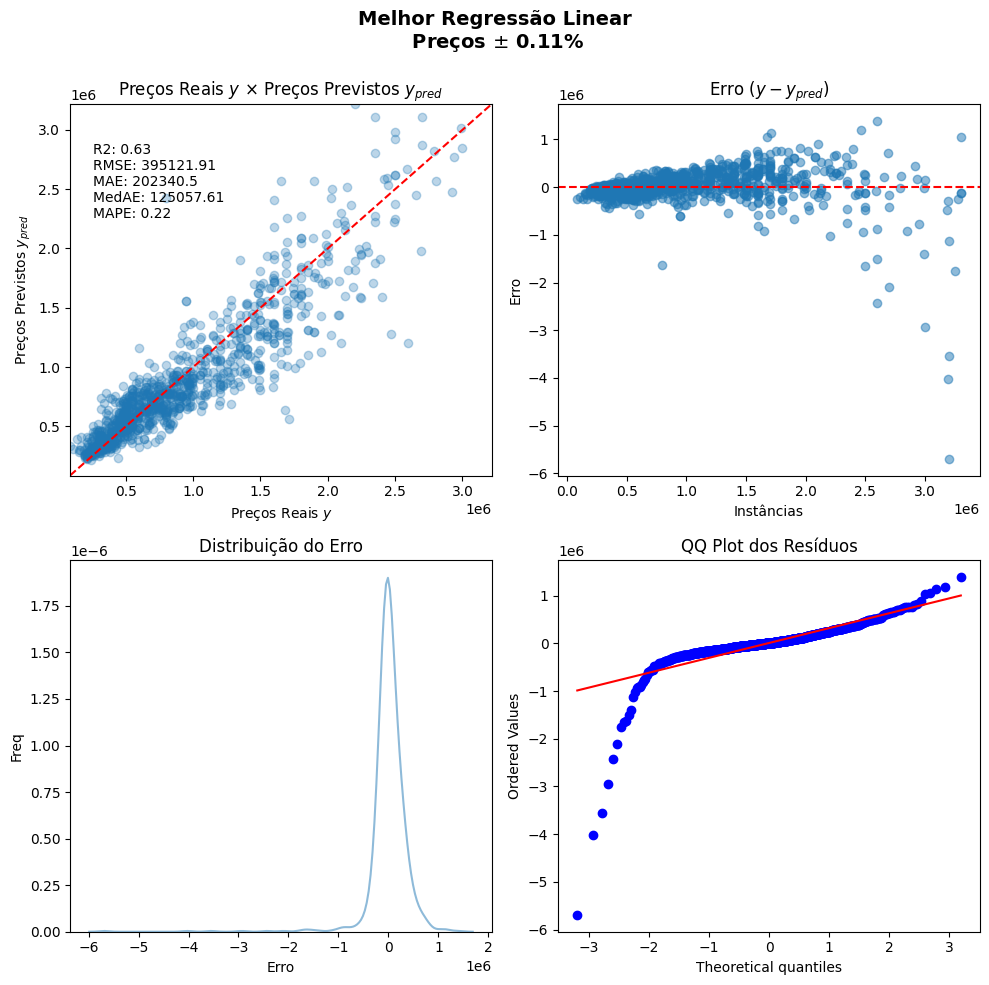

In [121]:
def plot_results(y_true, y_pred, titulo, qmin=0, qmax=1, qqplot=True, title_result=True):
  import statsmodels.api as sm
  import scipy.stats as stats

  fig, ax = plt.subplots(2,2,figsize=(10,10))
  ax = ax.flatten()

  if title_result:
    erro = error_metrics(y_true, y_pred)['MAPE']/2
    plt.suptitle(titulo + f'\n Preços $\\pm$ {erro:.2f}%',fontsize=14,weight='bold')
  else:
    plt.suptitle(titulo,fontsize=14,weight='bold')

  lim_min = min(np.quantile(y_true, qmin),np.quantile(y_pred, qmin))
  lim_max = max(np.quantile(y_true, qmax),np.quantile(y_pred, qmax))
  ax[0].set_xlim([lim_min,lim_max])
  ax[0].set_ylim([lim_min,lim_max])

  ax[0].scatter(y_true, y_pred, alpha=0.3)
  ax[0].plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--')
  ax[0].set_xlabel('Preços Reais $y$')
  ax[0].set_ylabel('Preços Previstos $y_{pred}$')
  ax[0].set_title('Preços Reais $y$ $\\times$ Preços Previstos $y_{pred}$')
  # Adicione um quadro com as métricas de erro
  metrics_text = '\n'.join([f"{key}: {value}" for key, value in error_metrics(y_true, y_pred).items()])
  ax[0].text(ax[0].get_xlim()[1]*0.08, ax[0].get_ylim()[1]*0.7, metrics_text, fontsize=10)

  ax[1].scatter(y_true, y_true - y_pred, alpha=0.5)
  ax[1].axhline(y=0, color='r', linestyle='--')
  ax[1].set_xlabel('Instâncias')
  ax[1].set_ylabel('Erro')
  ax[1].set_title('Erro $(y - y_{pred})$')

  sns.kdeplot(x = y_true - y_pred, alpha=0.5, ax=ax[2])
  ax[2].set_xlabel('Erro')
  ax[2].set_ylabel('Freq')
  ax[2].set_title('Distribuição do Erro')

  if qqplot:
    # QQ plot for residuals
    stats.probplot(y_true - y_pred, dist="norm", plot=ax[3])
    ax[3].set_title('QQ Plot dos Resíduos')
  else:
    ax[3].scatter(y, np.abs((y_true - y_pred)) / y_true, alpha=0.5)
    ax[3].axhline(y=0, color='r', linestyle='--')
    ax[3].set_xlabel('Instâncias')
    ax[3].set_ylabel('MAPE')
    ax[3].set_title('MAPE $abs(y - y_{pred})/y$')

  plt.tight_layout()
  plt.show()

plot_results(y_true, y_pred, 'Melhor Regressão Linear', qmax=0.98)

# Machine Learning Models

In [35]:
%%time
model_test_name = '***'

df_model = df.copy()

# if you need to use a small sample
# np.random.seed(42)
# df_model = df_model.iloc[ np.random.choice(df.index, size=1000, replace=False) ]

df_model.drop(['title','img_index'], axis=1, inplace=True)

X = df_model.drop('price', axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# numeric transformer = StandardScaler
numeric_features = df_model.drop('price', axis=1).select_dtypes(include=['number']).columns.tolist()
numeric_transformer = StandardScaler()

# combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

# pipeline com pré-processamento e modelo
modelo = RandomForestRegressor() # default

modelos = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=1000, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'HuberRegressor': HuberRegressor(max_iter=1000),
    'RANSACRegressor': RANSACRegressor(),
    'TheilSenRegressor': TheilSenRegressor()
}

model = make_pipeline(preprocessor, modelo)

# model parameters
param_grid = {
    'Decision Tree': {},
    'Random Forest': {},
    'Linear Regression': {},
    'Ridge Regression': {},
    'Lasso Regression': {},
    'Gradient Boosting': {},
    'K-Nearest Neighbors': {'n_neighbors':range(5,11)},
    'HuberRegressor': {},
    'RANSACRegressor': {},
    'TheilSenRegressor': {}
}

# GridSearchCV
for model_name, model in modelos.items():

  model_test_name = model_name

  grid_search = GridSearchCV(
      estimator=model,
      param_grid=param_grid[model_name],
      cv=kf,
      scoring=scoring,
      refit='RMSE',
      return_train_score=True,
      n_jobs=-1  # utilize todos os núcleos do processador
  )

  # train GridSearchCV
  grid_search.fit(X_train, y_train)

  # Imprime os melhores parâmetros encontrados
  # print("Melhores parâmetros:", grid_search.best_params_)
  # print()

  results_dict[model_test_name + ' (CV)'] = cv_metrics(grid_search.cv_results_,grid_search)

  y_pred = grid_search.predict(X_test)
  results_dict[model_test_name + ' (test)'] = error_metrics(y_test, y_pred)

  grid_search.fit(X, y)
  y_pred = grid_search.predict(X)
  results_dict[model_test_name + ' (all)'] = error_metrics(y, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,Model,R2,RMSE,MAE,MedAE,MAPE
0,"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33
1,"Linear Regression, only significant coefs (all)",0.69,363393.70,261854.43,191251.04,0.33
2,"Linear Regression, log transformer (all)",0.67,373490.70,250244.71,155172.11,0.27
3,Decision Tree (CV),0.27,546747.59,358915.55,193695.20,0.41
4,Decision Tree (test),0.42,512713.70,347768.65,195000.50,0.41
5,Decision Tree (all),1.00,8.89,0.60,0.00,0.00
6,Random Forest (CV),0.66,373052.16,255488.21,158293.09,0.30
7,Random Forest (test),0.76,329438.77,222056.43,145815.74,0.27
8,Random Forest (all),0.96,130296.62,88421.16,57367.88,0.10
9,Linear Regression (CV),0.65,380773.76,273151.41,195334.60,0.34



CPU times: user 33.6 s, sys: 2.39 s, total: 36 s
Wall time: 2min 39s


In [36]:
results_df.sort_values(by='RMSE', ascending=True)

,R2,RMSE,MAE,MedAE,MAPE
Decision Tree (all),1.00,8.89,0.60,0.00,0.00
Gradient Boosting (all),0.99,71283.11,50316.73,35095.12,0.07
Random Forest (all),0.96,130296.62,88421.16,57367.88,0.10
Random Forest (test),0.76,329438.77,222056.43,145815.74,0.27
Gradient Boosting (test),0.75,336267.52,225367.68,146332.97,0.27
"Linear Regression, all coefs (all)",0.70,357826.18,255581.45,186409.49,0.33
Linear Regression (all),0.70,357826.18,255581.45,186409.49,0.33
Lasso Regression (all),0.70,357826.19,255582.16,186382.17,0.33
Ridge Regression (all),0.70,358061.32,255868.60,185571.47,0.33
TheilSenRegressor (test),0.72,360653.48,261509.57,208875.59,0.35


In [37]:
latex_table = gera_df_stats_latex(results_df,'Results')
display(Latex(latex_table))


<IPython.core.display.Latex object>

In [ ]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Tempo de execução: {execution_time/60:.2f} min")